# Download dataset from source

In [ ]:
import gdown

# Download the CarDD dataset from Google Drive
url = "https://drive.google.com/uc?id=1bbyqVCKZX5Ur5Zg-uKj0jD0maWAVeOLx"
gdown.download(url, output="cardd_dataset.zip", quiet=False)


You can then extract the dataset as follows:

In [ ]:
!unzip cardd_dataset.zip

### Load into FiftyOne Format

FiftyOne [supports importing datasets from disk in various formats](https://beta-docs.voxel51.com/fiftyone_concepts/dataset_creation/), and it can be extended to import datasets in custom formats. The basic recipe involves specifying the path(s) to the data on disk and the type of dataset you’re loading. 

You can import a dataset from disk via [the `from_dir()` method](https://beta-docs.voxel51.com/api/fiftyone.core.dataset.Dataset.html#from_dir). 

Read the docs for full detail on all [supported formats](https://beta-docs.voxel51.com/fiftyone_concepts/dataset_creation/datasets/#loading-datasets-from-disk).

The CarDD dataset is in COCO format, so you can use [FiftyOne's built-in importer for COCO dataset](https://beta-docs.voxel51.com/fiftyone_concepts/dataset_creation/datasets/#cocodetectiondataset). 

The relevant arguments we use here are:

• `data_path` - where the images reside on disk

• `labels_path` - the path to the annotations, which should be a `json` file

• `dataset_type` - let' FiftyOne know we are loading a Dataset in COCO format

Read [the docs to learn more](https://beta-docs.voxel51.com/api/fiftyone.utils.coco.html#fiftyone.utils.coco.COCODetectionDatasetImporter) about working with datasets in COCO format.

In [ ]:
import fiftyone as fo

dataset = fo.Dataset.from_dir(
    data_path="CarDD_release/CarDD_COCO/train2017",
    labels_path="CarDD_release/CarDD_COCO/annotations/instances_train2017.json",
    dataset_type=fo.types.COCODetectionDataset,
    name="car_dd",
    overwrite=True,
    include_id=True,
)

You can call the dataset to see it's associated fields:

In [ ]:
dataset

Let's [persist the Dataset](https://beta-docs.voxel51.com/fiftyone_concepts/using_datasets/#dataset-persistence) as non-persistent datasets are deleted from the database each time the database is shut down. Note, you could define dataset persistence when you create the dataset by passing `persistent=True` into the `from_dir` method above.

In [6]:
dataset.persistent = True

You can also call [the first Sample of the Dataset](https://beta-docs.voxel51.com/api/fiftyone.core.dataset.Dataset.html#first) to see what the Fields looks like:

In [ ]:
dataset.first()

Notice that bounding box detections and the segmentations are parsed as [FiftyOne Detection types](https://beta-docs.voxel51.com/api/fiftyone.core.labels.Detection.html).

FiftyOne Detections are relative bounding box coordinates in `[0, 1]` in the following format: `[top-left-x, top-left-y, width, height]`.



Since we are working with instance segmentation the labels are parsed via the Detection label type with `mask` defining an instance segmentation mask for the detection within its bounding box. These are parsed as a 2D binary or 0/1 integer `numpy` array.

# Alternatively, download dataset from Hugging Face Hub

FiftyOne has an [integration with Hugging Face](https://beta-docs.voxel51.com/integrations/huggingface/), which allows you to push and pull FiftyOne Datasets from the Hugging Face Hub.

Prerna has already [parsed this dataset into FiftyOne format and pushed it to the Hub](https://huggingface.co/datasets/prernadh/car-defect-detection). You can download it as follows:

In [ ]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

hub_dataset = load_from_hub(
    "prernadh/car-defect-detection",
    name="cardd_from_hub",
    persistent=True
    )


With your Dataset loaded into FiftyOne format, now is a good time to launch the App and perform a "visual vibe check" of its contents. 

You can launch the app in a notebook by running:

```python

import fiftyone as fo

fo.launch_app(hub_dataset)
```

Or, you can open your terminal and execute `fiftyone app launch`. This will open the App in a browser window, and you can select your Dataset from the dropdown menu.

# Exploration via FiftyOne App

High resolution images may take unnecessary time to load. Sometimes it's useful to create thumbnails of the full resolution images and load those in the App:

In [ ]:
import fiftyone.utils.image as foui

THUMBNAIL_SIZE = 224

foui.transform_images(
        hub_dataset,
        size=(-1, THUMBNAIL_SIZE),
        output_field="thumbnails_path",
        output_dir="thumbnails",
    )

You'll also need to set the following properties in your App config:

In [ ]:
hub_dataset.app_config.media_fields = ["filepath", "thumbnails_path"]
hub_dataset.app_config.grid_media_field = "thumbnails_path"
hub_dataset.save()  # must save after edits

You can use the App in a variety of ways to explore your Dataset. One way to do this is by making using of [the Dashboard plugin](https://github.com/voxel51/fiftyone-plugins/tree/main/plugins/dashboard), which allows you to create interactive dashboards and explore the Dataset in detail.

We'll discuss [using and developing plugins](https://beta-docs.voxel51.com/plugins/using_plugins/) later in this workshop, but for now let's go ahead and install the required plugin:

In [ ]:
!fiftyone plugins download \
    https://github.com/voxel51/fiftyone-plugins \
    --plugin-names @voxel51/dashboard

### Initial exploration via SDK

> If you're a seasoned Pandas user, you might want to learn more about performing Pandas-style queries in FiftyOne. Read [these docs to learn more](https://beta-docs.voxel51.com/tutorials/pandas_comparison/).

Let's explore the Dataset via the SDK before launching the FiftyOne App. From here on out, we will make use of the dataset that we have downloaded from the Hugging Face Hub

You'll make use of a [`ViewExpression`](https://beta-docs.voxel51.com/api/fiftyone.core.expressions.ViewExpression.html) and [`ViewField`](https://beta-docs.voxel51.com/api/fiftyone.core.expressions.ViewField.html) to perform aggregrations over fields of a FiftyOne dataset. Using `ViewField` allows efficient calculation across the entire dataset without manual iteration.  

You can learn more about aggregrations in FiftyOne by [reading these docs](https://beta-docs.voxel51.com/fiftyone_concepts/using_aggregations/) and learn more about creating `Views` in [these docs](https://beta-docs.voxel51.com/how_do_i/recipes/creating_views/).

Let's see the counts and types of damages in this dataset:

In [ ]:
from fiftyone import ViewField as F

hub_dataset.count_values(F"ground_truth.detections.label")

### Enriching the dataset

You notice that beyond the bounding boxes and segmentation masks, there is not much other information on this dataset. However, you can use Fiftyone to enrich your dataset. 

Something you might be interested in is the are of the bounding boxes. Let's start by adding this information. The code below will help us compute this value. Here's what is happening:

- `rel_bbox_area`: Calculates bounding box area (width * height) as fraction of image size

- `im_width, im_height`: Gets image dimensions from metadata

- `abs_area`: Converts relative area to pixels by multiplying with image dimensions

The code adds two fields to each detection:

1. `relative_bbox_area`: Area as fraction of image (0-1). Note: represent the percentage of the total image area.

2. `absolute_bbox_area`: Area in pixels




In [ ]:
from fiftyone import ViewField as F

rel_bbox_area = F("bounding_box")[2] * F("bounding_box")[3]

im_width, im_height = F("$metadata.width"), F("$metadata.height")

abs_area = rel_bbox_area * im_width * im_height

hub_dataset.set_values("ground_truth.detections.relative_bbox_area", rel_bbox_area).save()

hub_dataset.set_field("ground_truth.detections.absolute_bbox_area", abs_area).save()

With these values computed you can perform some useful aggregations, for example you  can compute the [upper and lower bounds of the bounding box areas](https://beta-docs.voxel51.com/api/fiftyone.core.collections.SampleCollection.html#bounds) as well as other summary statistics like mean and standard deviation.

In [ ]:
labels = hub_dataset.distinct("ground_truth.detections.label")

for label in labels:
    view = hub_dataset.filter_labels("ground_truth", F("label") == label)
    bounds = view.bounds("ground_truth.detections.relative_bbox_area")
    bounds = (bounds[0]*100, bounds[1]*100)
    area = view.mean("ground_truth.detections.relative_bbox_area")*100
    std = view.std("ground_truth.detections.relative_bbox_area")
    print("\033[1m%s:\033[0m Min: %.4f, Mean: %.4f, Std: %.4f, Max: %.4f" % (label, bounds[0], std, area, bounds[1]))

You can also filter to Samples which have a scratch which meets some condition (as defined by their relative bounding box areas):

In [28]:
from fiftyone import ViewField as F

filter_to_scratch = F("label") == "scratch"

filter_to__boxes = F("relative_bbox_area") < 0.03

filtered_scratches = hub_dataset.match_labels(
    filter=(filter_to_scratch & filter_to_scratch), 
    fields="ground_truth.detections"
    )


You'll see that we have just created a View into our dataset:

In [ ]:
type(filtered_scratches)

You can save this view to the Dataset so that you can visualize them later in the FiftyOne App:

In [30]:
hub_dataset.save_view("filtered_scratches", filtered_scratches)

If, for whatever reason, you want to delete a View you can run:

```python
hub_dataset.delete_saved_view("<view-name>")
```

Or delete all the saved Views as follows:

```python
hub_dataset.delete_saved_views()
```


> Check out [this tutorial for more information](https://github.com/harpreetsahota204/Hands-on-Data-Centric-Visual-AI/blob/main/Module-2/Lesson_1_Exploring_Your_Dataset_with_FiftyOne.ipynb) about doing complex aggregations and filtering in FiftyOne

### Computing surface area of damages

This code takes a dataset of car damage images with their associated damage annotations and converts their representation into a more useful format. 

1. First, it extracts all the ground truth detection masks from the dataset using the [`values` method](https://beta-docs.voxel51.com/api/fiftyone.core.aggregations.Values.html) of the Dataset. 

2. It then prepares to convert these masks into a [FiftyOne Polyline](https://beta-docs.voxel51.com/api/fiftyone.core.labels.Polyline.html), which are essentially outlines of the damaged areas defined by a series of connected points. 

3. The code then goes through each image's detections one by one:
   - For each image that has damage annotations, it converts all the damage masks into a FiftyOne Polyline.
   - If an image has no damage annotations, it creates an empty list instead
   - It packages these polylines into a [FiftyOne Polylines](https://beta-docs.voxel51.com/api/fiftyone.core.labels.Polylines.html), which is just a a list of Polylines or polygons in an image.

4. Finally, it adds all these polyline representations back to the dataset as a new field called `polylines`. 

This conversion is useful because polylines can be easier to work with for certain types of analysis, like calculating the area of damaged regions or visualizing the boundaries of damage. It's like having both a coloring book (the masks) and just the outlines (the polylines) - each format has its own advantages for different tasks.


In [109]:
# Get all ground truth detection masks from the dataset
# This returns a list of Detections objects, one per sample
segmentation_masks = hub_dataset.values("ground_truth.detections")

# Initialize an empty list to store polyline representations for each sample
all_polylines = []

# Iterate through detections for each sample in the dataset
for sample_segmentation in segmentation_masks:
    # For each detection in the sample, convert its segmentation mask to a polyline
    # If sample has no detections (None), create empty list
    polylines = [segmentation.to_polyline() for segmentation in sample_segmentation] if sample_segmentation else []
    
    # Create a FiftyOne Polylines field containing the polyline representations
    polylines_field = fo.Polylines(
        polylines=polylines,
        closed=True,
        filled=True,
        )
    
    # Add the polylines for this sample to our list
    all_polylines.append(polylines_field)

# Add the polylines field to every sample in the dataset
# This creates a new field called "polylines" containing the polyline representations
hub_dataset.set_values("polylines", all_polylines)

Now we can define a function which will compute the area of a polygon:

In [ ]:
import numpy as np

def compute_polygon_area(points, image_width, image_height):
    """
    Compute the area of a polygon in pixel units using the Shoelace formula.
    
    Args:
        points: List of (x,y) coordinates defining the polygon vertices, normalized to [0,1]
        image_width: Width of the image in pixels
        image_height: Height of the image in pixels
        
    Returns:
        float: Area of the polygon in square pixels
        
    Notes:
        The Shoelace formula (also known as the surveyor's formula) calculates the area 
        of a polygon by using the coordinates of its vertices. The formula gets its name
        from the way the computation "laces" together vertex coordinates.
    """
    # Convert points list to numpy array for vectorized operations
    points = np.array(points)
    
    # Scale normalized coordinates back to pixel dimensions
    points[:, 0] *= image_width  # Scale x coordinates
    points[:, 1] *= image_height # Scale y coordinates
    
    # Extract x and y coordinates into separate arrays
    x = points[:, 0]
    y = points[:, 1]
    
    # Create shifted versions of coordinate arrays
    # np.roll shifts array elements by 1 position for the formula
    x_shift = np.roll(x, 1)
    y_shift = np.roll(y, 1)
    
    # Apply Shoelace formula: A = 1/2 * |sum(x_i*y_i+1 - x_i+1*y_i)|
    return 0.5 * np.abs(np.sum(x * y_shift - x_shift * y))


Finally, we can add in the absolute and relative surface areas

In [130]:
import numpy as np

for sample in hub_dataset:
    # Get the points - take the first list from the nested structure
    points = np.array(sample.polylines.polylines[0].points[0])  # Note the [0] to get first list
    
    # Get image dimensions
    width = sample.metadata.width
    height = sample.metadata.height
    
    # Compute area using the helper function
    absolute_surface_area = compute_polygon_area(points, width, height)

    relative_surface_area = area / (width * height)
    
    # Store both relative and absolute areas
    sample.polylines.polylines[0].relative_surface_area = relative_surface_area
    sample.polylines.polylines[0].absolute_surface_area = absolute_surface_area
    
    # Save the sample
    sample.save()

In [ ]:
labels = hub_dataset.distinct("polylines.polylines.label")

for label in labels:
    view = hub_dataset.filter_labels("polylines", F("label") == label)
    bounds = view.bounds("polylines.polylines.relative_bbox_area")
    bounds = (bounds[0]*100, bounds[1]*100)
    area = view.mean("polylines.polylines.relative_bbox_area")*100
    std = view.std("polylines.polylines.relative_bbox_area")
    print("\033[1m%s:\033[0m Min: %.4f, Mean: %.4f, Std: %.4f, Max: %.4f" % (label, bounds[0], std, area, bounds[1]))

In [133]:
import pandas as pd

df = pd.read_excel("CarDD_release/CarDD_COCO/annotations/image_info.xlsx")

### Using VLMs for data enrichment

You can use Vision Language Models (VLMs) to enrich car damage analysis in some interesting ways:

1. **Basic Captioning:** Generate descriptions of damage type, severity, and affected car parts in natural language.

2. **Detailed Location:** Convert basic annotations (like "dent on door") into precise descriptions (like "dent on lower passenger door near handle").

3. **Damage Cause Analysis:** Infer potential causes from visual clues (e.g., "scratch likely from brushing against object").

4. **Scene Context:** Describe relevant environmental factors (e.g., "parked car, daylight conditions, clean vehicle").

5. **Multi-Damage Relations:** Explain how multiple damages relate (e.g., "scratch running across dent" or "cluster of dents").

6. **Component Recognition:** Identify and label both damaged and undamaged car parts for better context.


FiftyOne allows you to use VLMs rather seemlessly, for example [Qwen2.5-VL is a VLM](https://github.com/harpreetsahota204/qwen2_5_vl) which has been integrated as a [Remotely Sourced Zoo Model](https://beta-docs.voxel51.com/models/model_zoo/remote/) (which we will discuss later).

Start by registering the model:

In [136]:
import fiftyone.zoo as foz

foz.register_zoo_model_source("https://github.com/harpreetsahota204/qwen2_5_vl")

Next, you can download a checkpoint. Refer to the [Qwen2.5-VL's Remote Zoo Model's GitHub](https://github.com/harpreetsahota204/qwen2_5_vl/tree/main) to see the available checkpoints.

In [ ]:
foz.download_zoo_model(
    "https://github.com/harpreetsahota204/qwen2_5_vl",
    model_name="Qwen/Qwen2.5-VL-3B-Instruct"
)

Then you can load the model as you would any [Built-in Zoo Model](https://beta-docs.voxel51.com/models/model_zoo/models/).

Ttart by setting `operation="vqa"`, which we will use to generate answers/captions for each image:

In [ ]:
zoo_model = foz.load_zoo_model(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    operation="vqa"
    # install_requirements=True #if you are using for the first time and need to download reuirement,
    # ensure_requirements=True #  ensure any requirements are installed before loading the model
)

You can set the prompt for the model by as follows:

In [139]:
zoo_model.prompt="Complete a damage report for this vehicle in this image. Include details about the damage, including the location and type of damage. If there is no damage, say 'No damage'."

And then apply the model to your Dataset via [the `apply_model` method](https://beta-docs.voxel51.com/api/fiftyone.core.models.html#apply_model) of the Dataset.

Image captioning/VQA typically takes longer other operations. This took ~17 minutes to run on a single NVIDIA RTX 600 Ada.

In [142]:
hub_dataset.apply_model(zoo_model, label_field="damage_report")

 100% |█████████████████| 374/374 [16.7m elapsed, 0s remaining, 0.4 samples/s]    


You can also use the model for classification, for example to get the color of the vehicle. All you have to do is:

In [143]:
zoo_model.operation="classify"
zoo_model.prompt = "What is the color of the damaged vehicle in this image? Please provide the color name."
hub_dataset.apply_model(zoo_model, label_field="vehicle_color")

 100% |█████████████████| 374/374 [6.0m elapsed, 0s remaining, 1.0 samples/s]      


You can also classify the location of the damage:

In [152]:
zoo_model.prompt = """You are required to report the location of vehicle damage. \
    List all the locations where this vehicle has been damaged. Choose from one or more of the following, or include any location not explicitly listed: 
    - quarter panel
    - driver door
    - passenger door
    - rear door
    - hood
    - front bumper
    - rear bumper
    - quarter panel
    - tires
    - rim 
    - wheel well     
    
    Where all the locations where this vehicle has been damaged?"""

hub_dataset.apply_model(zoo_model, label_field="damage_location")

 100% |█████████████████| 374/374 [7.2m elapsed, 0s remaining, 0.8 samples/s]    


Let's briefly explore what the VLM has come up with. For context, let's open the first image and examine the model output:

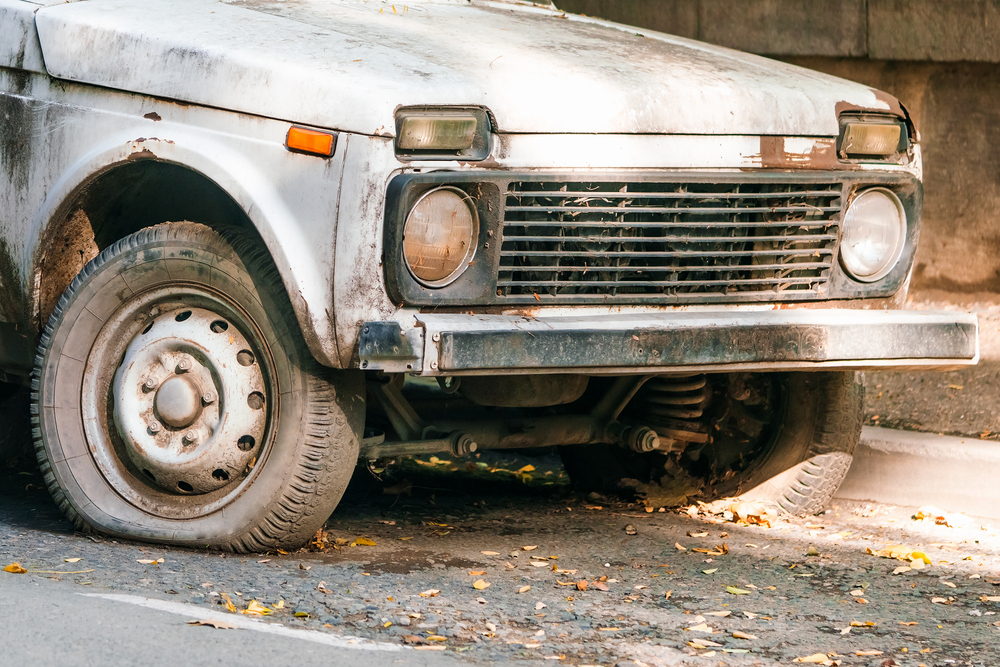

In [145]:
from PIL import Image

Image.open(hub_dataset.first().filepath)

In [150]:
print(hub_dataset.first().damage_report)

The vehicle in the image has significant damage to its front left wheel well. The tire appears to be completely missing or severely damaged, exposing the inner components of the wheel well. There is also visible rust and wear on the front bumper and grille area, indicating long-term exposure to the elements. The overall condition suggests that the vehicle may have been involved in an accident or has been exposed to harsh conditions over time.


In [147]:
hub_dataset.first().vehicle_color

<Classifications: {
    'classifications': [
        <Classification: {
            'id': '67f43624f366634a172d0fd6',
            'tags': [],
            'label': 'gray',
            'confidence': None,
            'logits': None,
        }>,
        <Classification: {
            'id': '67f43624f366634a172d0fd7',
            'tags': [],
            'label': 'rusty',
            'confidence': None,
            'logits': None,
        }>,
    ],
    'logits': None,
}>

In [153]:
hub_dataset.first().damage_location

<Classifications: {
    'classifications': [
        <Classification: {
            'id': '67f43c2ef366634a172d149e',
            'tags': [],
            'label': 'front bumper',
            'confidence': None,
            'logits': None,
        }>,
        <Classification: {
            'id': '67f43c2ef366634a172d149f',
            'tags': [],
            'label': 'quarter panel',
            'confidence': None,
            'logits': None,
        }>,
    ],
    'logits': None,
}>

: 

You can also refresh the FiftyOe App and view the model output for each sample in the Dataset.